# LUAD survival analysis

#### Data sources:
- `rna_cancer_sample.tsv`: Human Protein Atlas (https://www.proteinatlas.org/download/rna_cancer_sample.tsv.zip)
- `clinical.tsv`: TCGA (https://portal.gdc.cancer.gov/projects/TCGA-LUAD; click Clinical download button)

Data were pre-normalized as part of the Human Protein Atlas project

#### Table of contents:
<ul>
    <li><a href="#import">Import dependencies</a></li>
    <li><a href="#functions">Functions</a></li>
    <li><a href="#read">Read gene expression data and format</a></li>
    <li><a href="#censor">Read clinical data and format/censor</a></li>
    <li><a href="#summary">Data summaries</a></li>
    <li><a href="#sms">SMS (ENSG00000102172)</a></li>
        <ul>
           <li>All stages</li>
           <li>Early stages</li>
           <li>Late stages</li>
        </ul>
    <li><a href="#glyctk">GLYCTK (ENSG00000168237)</a></li>
        <ul>
           <li>All stages</li>
           <li>Early stages</li>
           <li>Late stages</li>
        </ul>
    <li><a href="#all">Perform analysis on all genes</a></li>    
    <li><a href="#rank">Rank order survival p-values</a></li>   
        <ul>
           <li>SMS</li>
           <li>GLYCTK</li>
        </ul>
    <li><a href="#plots">Plots</a></li>
        <ul>
           <li>All stages</li>
           <li>Early stages</li>
           <li>Late stages</li>
        </ul>
    <li><a href="#session">Session Info</a></li>
</ul>

<a id="import"><h3>Import dependencies</h3></a>

In [1]:
suppressWarnings({
    library(survival)
    library(survminer)
    library(stringr)
    library(data.table)

    #setwd("C:/Users/jorda/Desktop/projects/manuscript/rna_cancer_data/tcga_classic/")
})

Loading required package: ggplot2

Loading required package: ggpubr



<a id="functions"><h3>Functions</h3></a>

In [2]:
# Clean and prepare clinical data 
censor_df <- function (df) {
    # Censor alive==0/dead==1
    # See "event" description at https://www.rdocumentation.org/packages/survival/versions/2.11-4/topics/Surv
    censor_data <- function(x) if (x == "Alive") {0} else {1}
    df$status <- mapply(censor_data, df$vital_status)
    df$status <- as.numeric(df$status)
    df$days_to_death <- as.numeric(df$days_to_death) ##################### <-------- NAs
    
    # Right censor for alive
    # https://cran.r-project.org/web/packages/finalfit/vignettes/survival.html
    df$days_to_death <- ifelse(
        is.na(df$days_to_death), 
        df$days_to_last_follow_up, 
        df$days_to_death)
    
    df$days_to_death <- ifelse(
        df$days_to_death == "'--", 
        df$days_to_last_follow_up, 
        df$days_to_death)
    
    return (df)
}

clean_df <- function(df) {
    # Get relevant data and perform some additional data clean-up
    df <- df[ , c("case_submitter_id", "ajcc_pathologic_stage", "status", "days_to_death", "days_to_last_follow_up")] 

    # remove duplicate entries
    df <- unique(df[,])

    # remove samples with no days to death after censoring
    df <- df[df$days_to_death != "'--", ]

    # Make sure output formatting is correct
    df$status <- as.numeric(as.character(df$status))
    df$days_to_death <- as.numeric(as.character(df$days_to_death))
    
    return (df)
}

parse_stages <- function(df) {
    
    # Add stage category labels
    df$stage <- df$ajcc_pathologic_stage
    df <- df[df$stage != "'--", ]
    df$stage[
        df$stage == "Stage I" | 
        df$stage == "Stage IA" | 
        df$stage == "Stage IB"] <- 1
    df$stage[
        df$stage == "Stage II" | 
        df$stage == "Stage IIA" | 
        df$stage == "Stage IIB"] <- 2
    df$stage[
        df$stage == "Stage III" | 
        df$stage == "Stage IIIA" | 
        df$stage == "Stage IIIB"] <- 3
    df$stage[
        df$stage == "Stage IV" | 
        df$stage == "Stage IVA" | 
        df$stage == "Stage IVB"] <- 4

    # Parse out early vs. late patients
    early <- df[
        df$ajcc_pathologic_stage == "Stage I" | 
        df$ajcc_pathologic_stage == "Stage IA" | 
        df$ajcc_pathologic_stage == "Stage IB", ]
    late <- df[
        df$ajcc_pathologic_stage != "Stage I" & 
        df$ajcc_pathologic_stage != "Stage IA" & 
        df$ajcc_pathologic_stage != "Stage IB", ]
    all <- df
    
    v = list(all, early, late)
    names(v) <- c("all", "early", "late")
    
    return (v)
}

In [3]:
plot_day_dist <- function(df, export=FALSE) {
    if (export != FALSE) {
        pdf(export)
    }
    
    # initialize plotting space 
    par(mfrow=c(1,2), pin=c(3,1))
    
    # plot days to death for dead patients distribution
    x1 <- df[df$status == 1, ]$days_to_death
    h1 <-hist(x1, breaks=20, col="red", xlab="Days to Death", main="Dead")
    xfit1<-seq(min(x1),max(x1),length=40)
    yfit1<-dnorm(xfit1,mean=mean(x1),sd=sd(x1))
    yfit1 <- yfit1*diff(h1$mids[1:2])*length(x1)
    lines(xfit1, yfit1, col="red", lwd=2)
    
    # plot days to follow-up for alive patients distribution
    x2 <- df[df$status == 0, ]$days_to_death
    h2 <- hist(x2, breaks=20, col="blue", xlab="Days to Follow-up", main="Alive")
    xfit2<-seq(min(x2),max(x2),length=40)
    yfit2<-dnorm(xfit2,mean=mean(x2),sd=sd(x2))
    yfit2 <- yfit2*diff(h2$mids[1:2])*length(x2)
    lines(xfit2, yfit2, col="blue", lwd=2)
    
    if (export != FALSE) {
        dev.off()
    }
}

plot_gene_summary <- function(df, gene, title=NULL, export=FALSE, color="blue") {
    if (export != FALSE) {
        pdf(export)
    }
    
    if (is.null(title)) {
        title = gene
    }
    
    print(paste(title, "gene expression summary"))
    print(summary(df[df$Gene == gene,]$FPKM))

    x2 <- df[df$Gene == gene, ]$FPKM
    h2 <- hist(x2, breaks=100, col="grey", xlab="FPKM", main=title)
    xfit2<-seq(min(x2),max(x2),length=40)
    yfit2<-dnorm(xfit2,mean=mean(x2),sd=sd(x2))
    yfit2 <- yfit2*diff(h2$mids[1:2])*length(x2)
    lines(xfit2, yfit2, col="blue", lwd=2)
    
    if (export != FALSE) {
        dev.off()
    }
}

In [4]:
analyze_all_genes <- function(expression, clinical, gene_list) {
    
    median_pvals <-list()
    optimized_pvals <- list()
    counter <- 0

    for (gene in gene_list) {
      tryCatch({
        data_gene <- expression[expression$Gene == gene,]
        # Merged mixed data tables
        merged_data_gene <- merge(
          data_gene,
          clinical,
          by.x = "Sample",
          by.y = "case_submitter_id")

        this_median <- median(merged_data_gene$FPKM)
        merged_data_gene$gene_status <- ifelse(merged_data_gene$FPKM > this_median, "high", "low")
        km_trt_fit <- surv_fit(Surv(days_to_death, status) ~ gene_status, data=merged_data_gene)

        opt_cutoff <- surv_cutpoint(
            merged_data_gene, 
            time = "days_to_death", 
            event = "status", 
            variables = c("FPKM"),
            minprop=0.2)
        opt_categories <- surv_categorize(opt_cutoff)
        opt_fit <- surv_fit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)

        median_pvals[gene] <- surv_pvalue(km_trt_fit)$pval
        optimized_pvals[gene] <- surv_pvalue(opt_fit)$pval
          
      }, error = function (condition) {
        counter <- counter + 1
      })
    }
    print(paste("Skipped", counter, "genes", sep=" "))
    
    v = list(median_pvals, optimized_pvals)
    names(v) <- c("median", "optimized")
    
    return (v)
}

In [5]:
plot_scatter <- function(expression, clinical, gene, title=NULL, export=FALSE) {
    if (export != FALSE) {
        pdf(export)
    }
    
    if (is.null(title)) {
        title = gene
    }
    
    print(title)
    data_gene <- expression[expression$Gene == gene,]
    merged_data_gene <- merge(
      data_gene,
      clinical,
      by.x = "Sample",
      by.y = "case_submitter_id")

    plot(merged_data_gene$FPKM, merged_data_gene$days_to_death)
    
    if (export != FALSE) {
        dev.off()
    }
}

In [6]:
get_best_cutoff <- function(expression, clinical, gene, title=NULL, stage="All", minprop=0.2) {
    if (is.null(title)) {
        title = gene
    }
    print(paste(stage, ":::", title))
    
    # K-M Curve
    data_gene <- expression[expression$Gene == gene,]
    # Merged mixed data tables
    merged_data_gene <- merge(
      data_gene,
      clinical,
      by.x = "Sample",
      by.y = "case_submitter_id")
    
    # Optimized threshold
    opt_cutoff <- surv_cutpoint(
        data = merged_data_gene, 
        time = "days_to_death", 
        event = "status", 
        variables = c("FPKM"),
        minprop=minprop)
    opt_categories <- surv_categorize(x = opt_cutoff)
    opt_fit <- surv_fit(formula = Surv(days_to_death, status) ~ FPKM, data = opt_categories)
    
    # Get p-values
    val_opt <- surv_pvalue(opt_fit)$pval

    # Print stats
    print(paste("Optimized cutoff:", opt_cutoff$cutpoint$cutpoint))
    print(paste("Best fit p-value:", val_opt))
    print(paste("high:", sum(str_count(opt_categories$FPKM, "high"))))
    print(paste("low:", sum(str_count(opt_categories$FPKM, "low"))))

    # Cox Regression
    res.cox <- coxph(Surv(days_to_death, status) ~ FPKM, data=opt_categories)
    print(summary(res.cox))
 
    best_value = list(opt_fit, opt_cutoff, opt_cutoff$cutpoint$cutpoint, opt_categories, val_opt)
    names(best_value) = list("model", "cutoff_obj", "cutoff", "categories", "p_val")
    return (best_value)
}

use_cutoff <- function(expression, clinical, gene, cutoff, title=NULL, stage="All") {
    if (is.null(title)) {
        title = gene
    }
    print(paste(stage, ":::", title))
    
    data_gene <- expression[expression$Gene == gene,]
    # Merged mixed data tables
    merged_data_gene <- merge(
      data_gene,
      clinical,
      by.x = "Sample",
      by.y = "case_submitter_id")

    merged_data_gene$gene_status <- ifelse(merged_data_gene$FPKM > cutoff, "high", "low")
    opt_fit <- surv_fit(Surv(days_to_death, status) ~ gene_status, data=merged_data_gene)

    # Get p-values
    val_opt <- surv_pvalue(opt_fit)$pval

    # Print stats
    print(paste("Used cutoff:", cutoff))
    print(paste("Used p-value:", val_opt))
    print(paste("high:", sum(str_count(merged_data_gene$gene_status, "high"))))
    print(paste("low:", sum(str_count(merged_data_gene$gene_status, "low"))))
    
    res.cox <- coxph(Surv(days_to_death, status) ~ gene_status, data=merged_data_gene)
    print(summary(res.cox))
    
    best_value = list(opt_fit, val_opt)
    names(best_value) = list("model", "p_val")
    return (best_value)
}

<a id="read"><h3>Read gene expression data and format</h3></a>

In [7]:
rpkm_data <- read.csv(
    file = 'rna_cancer_sample.tsv', 
    sep="\t")

# Extract LUAD data
rpkm_data <- rpkm_data[rpkm_data$Cancer == 'LUAD',]

# Clean up Sample IDs
rpkm_data$Sample <- sapply(strsplit(rpkm_data$Sample, "-01A"), "[", 1)
gene_list <- unique(rpkm_data$Gene)
rpkm_data$FPKM <- as.numeric(rpkm_data$FPKM)

dim(rpkm_data)

[1] 9728500       4

<a id="censor"><h3>Read clinical data and format/censor</h3></a> 

In [8]:
clinical_data <- read.csv(
    file = "clinical.tsv", 
    sep="\t")

clinical_data <- censor_df(
    clinical_data)
dim(clinical_data)

clinical_data <- clean_df(
    clinical_data)
dim(clinical_data)

clinical_data <- parse_stages(
    clinical_data)

Warning message in censor_df(clinical_data):
"NAs introduced by coercion"


[1] 1044  155

[1] 513   5

<a id="summary"><h3>Data summaries</h3></a>

In [9]:
# plot day distribtions for groups
plot_day_dist(
    clinical_data$all,
    export="patient_distribution.pdf")

png 
  2

In [10]:
plot_gene_summary(
    rpkm_data, 
    "ENSG00000102172", 
    "SMS",
    export="gene_summary_sms.pdf")

[1] "SMS gene expression summary"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.46   24.99   34.25   39.28   46.05  166.50 


png 
  2

In [11]:
plot_gene_summary(
    rpkm_data, 
    "ENSG00000168237", 
    "GLYCTK",
    export="gene_summary_glyctk.pdf")

[1] "GLYCTK gene expression summary"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1141  0.9718  1.3831  1.9098  2.0368 21.6683 


png 
  2

In [12]:
# Plot both in same plotting space

In [13]:
pdf("gene_summary_both.pdf", height=8, width=10)

# initialize plotting space 
par(mfrow=c(1,2), pin=c(3,3))

x1 <- rpkm_data[rpkm_data$Gene == "ENSG00000102172", ]$FPKM
h1 <- hist(x1, breaks=100, col="grey", xlab="FPKM", main="SMS")
xfit1<-seq(min(x1),max(x1),length=40)
yfit1<-dnorm(xfit1,mean=mean(x1),sd=sd(x1))
yfit1 <- yfit1*diff(h1$mids[1:2])*length(x1)
lines(xfit1, yfit1, col="blue", lwd=2)

x2 <- rpkm_data[rpkm_data$Gene == "ENSG00000168237", ]$FPKM
h2 <- hist(x2, breaks=100, col="grey", xlab="FPKM", main="GLYCTK")
xfit2<-seq(min(x2),max(x2),length=40)
yfit2<-dnorm(xfit2,mean=mean(x2),sd=sd(x2))
yfit2 <- yfit2*diff(h2$mids[1:2])*length(x2)
lines(xfit2, yfit2, col="blue", lwd=2)

dev.off()

png 
  2

### =========================================================================================

<a id="sms"><h3>SMS (ENSG00000102172)</h3></a>

#### All stages

[1] "SMS"


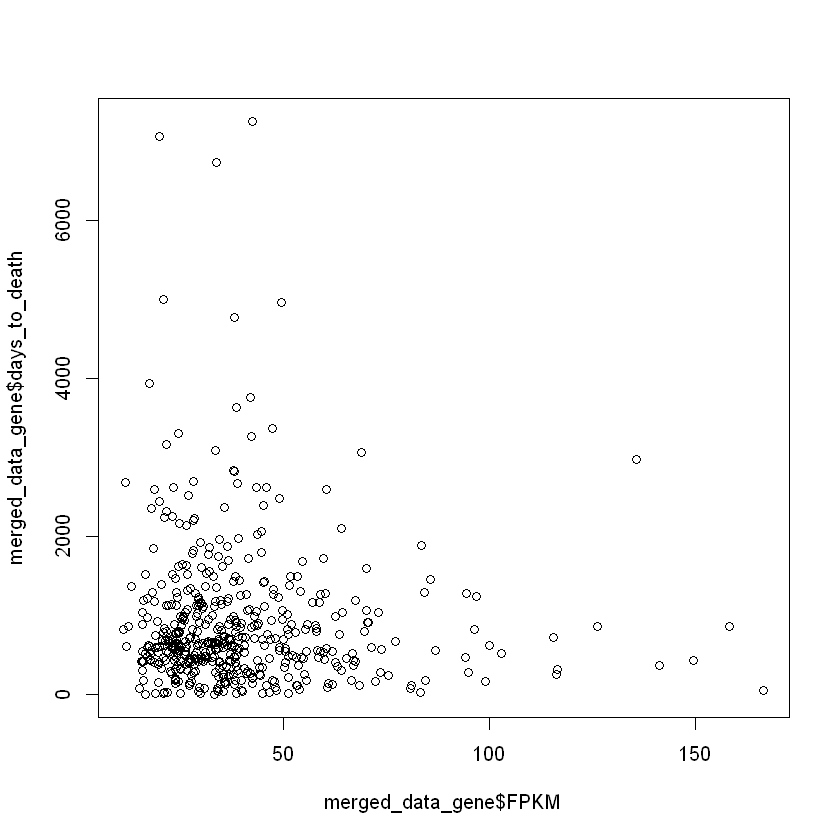

In [14]:
plot_scatter(
    rpkm_data, 
    clinical_data$all, 
    "ENSG00000102172", 
    "SMS")

In [15]:
best_values_sms_all <- get_best_cutoff(
    expression=rpkm_data, 
    clinical=clinical_data$all, 
    gene="ENSG00000102172", 
    title="SMS", 
    stage="All")

[1] "All ::: SMS"
[1] "Optimized cutoff: 49.5413"
[1] "Best fit p-value: 2.92888467053861e-06"
[1] "high: 105"
[1] "low: 382"
Call:
coxph(formula = Surv(days_to_death, status) ~ FPKM, data = opt_categories)

  n= 487, number of events= 177 

           coef exp(coef) se(coef)      z Pr(>|z|)    
FPKMlow -0.7461    0.4742   0.1632 -4.571 4.85e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
FPKMlow    0.4742      2.109    0.3444     0.653

Concordance= 0.567  (se = 0.019 )
Likelihood ratio test= 18.88  on 1 df,   p=1e-05
Wald test            = 20.89  on 1 df,   p=5e-06
Score (logrank) test = 21.87  on 1 df,   p=3e-06



In [16]:
pdf("stat_dist_sms_all.pdf")
plot(
    best_values_sms_all$cutoff_obj, 
    "FPKM", 
    palette = "npg", 
    bins = 50)$FPKM
dev.off()

png 
  2

In [17]:
model <- best_values_sms_all$model
p_val <- best_values_sms_all$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_sms_all.pdf", onefile=FALSE)
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    break.time.by=1826.25,
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

png 
  2

#### Early stages

[1] "SMS"


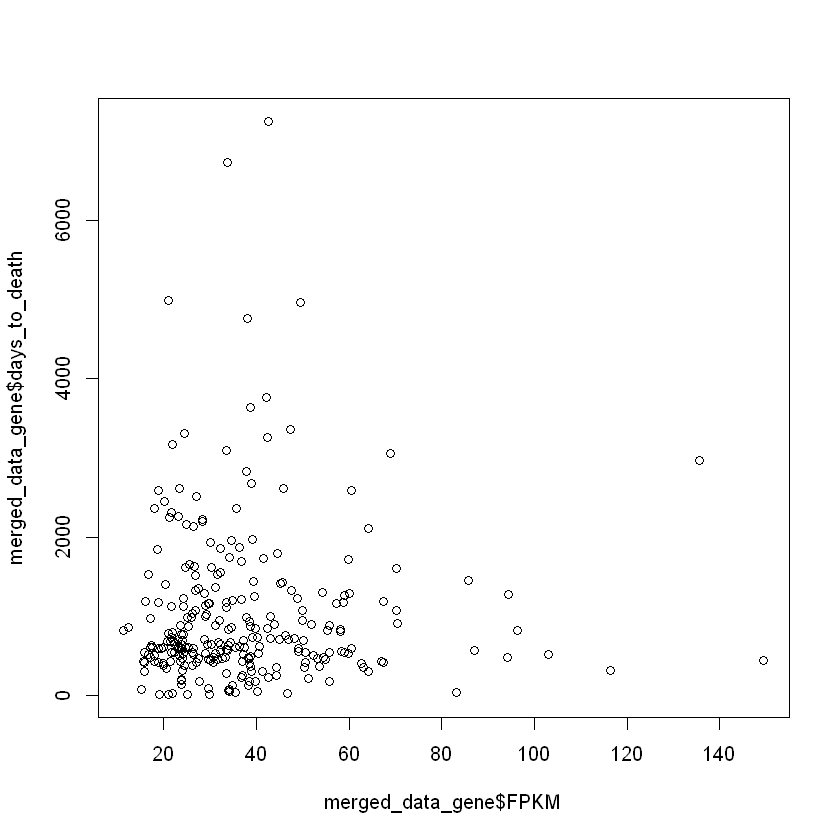

In [18]:
plot_scatter(
    rpkm_data, 
    clinical_data$early, 
    "ENSG00000102172", 
    "SMS")

In [19]:
use_values_early <- use_cutoff(
    rpkm_data, 
    clinical_data$early, 
    "ENSG00000102172", 
     best_values_sms_all$cutoff, 
    title="SMS", 
    stage="Early")

[1] "Early ::: SMS"
[1] "Used cutoff: 49.5413"
[1] "Used p-value: 0.00021161907604961"
[1] "high: 51"
[1] "low: 213"
Call:
coxph(formula = Surv(days_to_death, status) ~ gene_status, data = merged_data_gene)

  n= 264, number of events= 63 

                  coef exp(coef) se(coef)      z Pr(>|z|)    
gene_statuslow -0.9707    0.3788   0.2722 -3.566 0.000362 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

               exp(coef) exp(-coef) lower .95 upper .95
gene_statuslow    0.3788       2.64    0.2222    0.6459

Concordance= 0.585  (se = 0.034 )
Likelihood ratio test= 11.26  on 1 df,   p=8e-04
Wald test            = 12.72  on 1 df,   p=4e-04
Score (logrank) test = 13.73  on 1 df,   p=2e-04



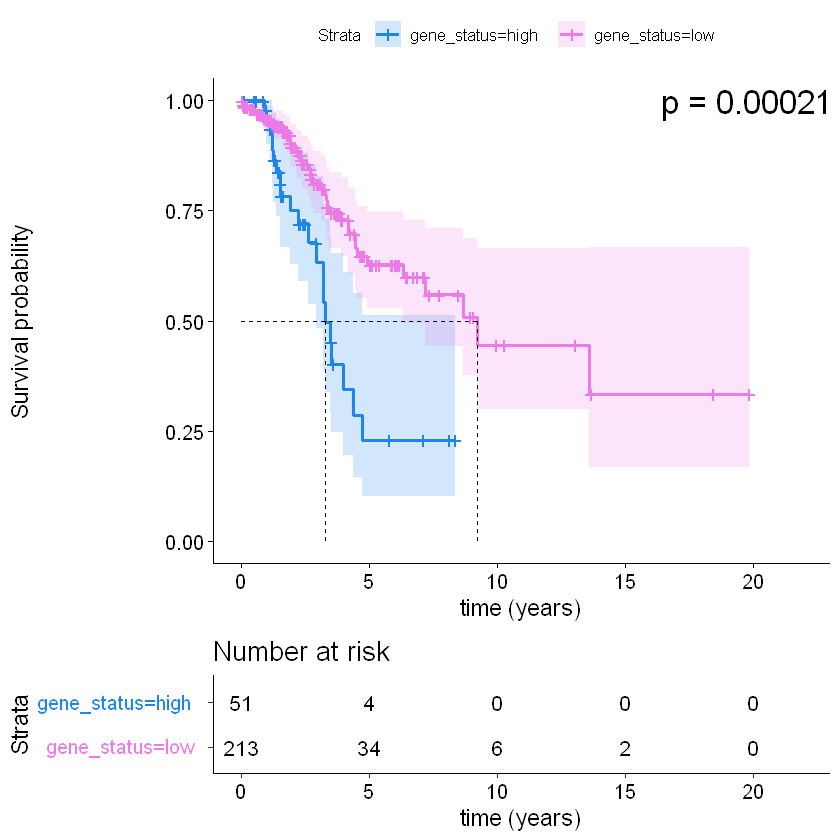

In [20]:
model <- use_values_early$model
p_val <- use_values_early$p_val
dig_round=7
p_pos=c(6000,1)

#pdf()
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    break.time.by=1826.25,
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
#dev.off()

In [21]:
best_values_sms_early <- get_best_cutoff(
    expression=rpkm_data, 
    clinical=clinical_data$early, 
    gene="ENSG00000102172", 
    title="SMS", 
    stage="early")

[1] "early ::: SMS"
[1] "Optimized cutoff: 48.239"
[1] "Best fit p-value: 0.000365689639380748"
[1] "high: 55"
[1] "low: 209"
Call:
coxph(formula = Surv(days_to_death, status) ~ FPKM, data = opt_categories)

  n= 264, number of events= 63 

           coef exp(coef) se(coef)      z Pr(>|z|)    
FPKMlow -0.9069    0.4038   0.2631 -3.447 0.000567 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
FPKMlow    0.4038      2.477    0.2411    0.6762

Concordance= 0.58  (se = 0.034 )
Likelihood ratio test= 10.7  on 1 df,   p=0.001
Wald test            = 11.88  on 1 df,   p=6e-04
Score (logrank) test = 12.7  on 1 df,   p=4e-04



In [22]:
pdf("stat_dist_sms_early.pdf")
plot(
    best_values_sms_early$cutoff_obj, 
    "FPKM", 
    palette = "npg", 
    bins = 50)$FPKM
dev.off()

png 
  2

In [23]:
model <- best_values_sms_early$model
p_val <- best_values_sms_early$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_sms_early.pdf", onefile=FALSE)
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    break.time.by=1826.25,
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

png 
  2

#### Late stages

[1] "SMS"


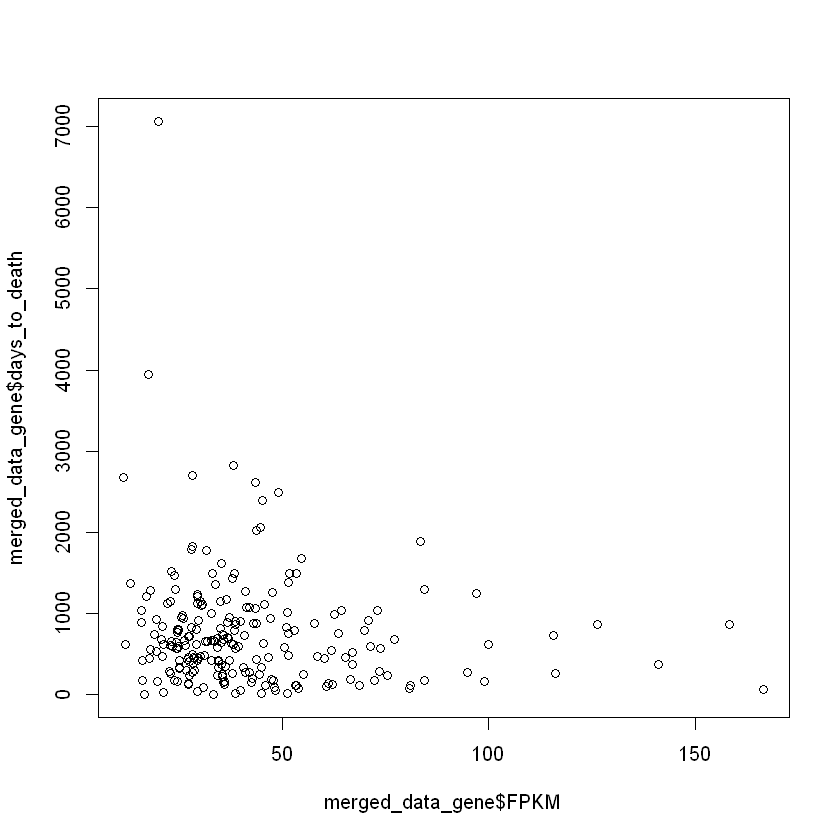

In [24]:
plot_scatter(
    rpkm_data, 
    clinical_data$late, 
    "ENSG00000102172", 
    "SMS")

In [25]:
use_values_late <- use_cutoff(
    rpkm_data, 
    clinical_data$late, 
    "ENSG00000102172", 
     best_values_sms_all$cutoff, 
    title="SMS", 
    stage="Late")

[1] "Late ::: SMS"
[1] "Used cutoff: 49.5413"
[1] "Used p-value: 0.00312343789508907"
[1] "high: 54"
[1] "low: 169"
Call:
coxph(formula = Surv(days_to_death, status) ~ gene_status, data = merged_data_gene)

  n= 223, number of events= 114 

                  coef exp(coef) se(coef)      z Pr(>|z|)   
gene_statuslow -0.5984    0.5497   0.2055 -2.911   0.0036 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

               exp(coef) exp(-coef) lower .95 upper .95
gene_statuslow    0.5497      1.819    0.3674    0.8224

Concordance= 0.558  (se = 0.024 )
Likelihood ratio test= 7.82  on 1 df,   p=0.005
Wald test            = 8.48  on 1 df,   p=0.004
Score (logrank) test = 8.73  on 1 df,   p=0.003



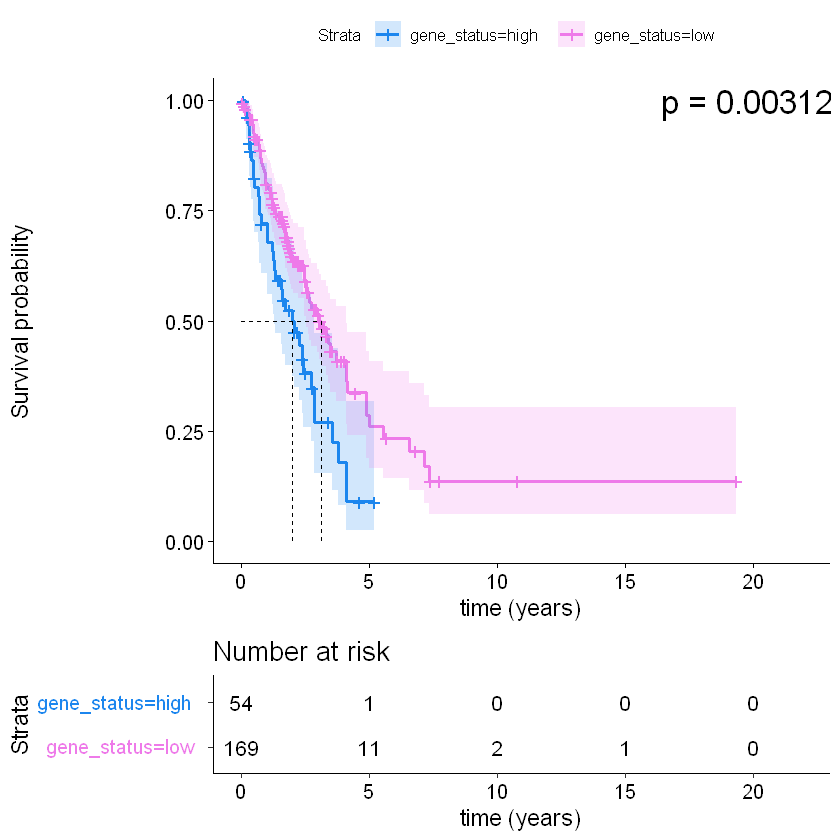

In [26]:
model <- use_values_late$model
p_val <- use_values_late$p_val
dig_round=7
p_pos=c(6000,1)

#pdf()
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    break.time.by=1826.25,
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
#dev.off()

In [27]:
best_values_sms_late <- get_best_cutoff(
    expression=rpkm_data, 
    clinical=clinical_data$late, 
    gene="ENSG00000102172", 
    title="SMS", 
    stage="late")

[1] "late ::: SMS"
[1] "Optimized cutoff: 24.971"
[1] "Best fit p-value: 0.00360953569815356"
[1] "high: 179"
[1] "low: 44"
Call:
coxph(formula = Surv(days_to_death, status) ~ FPKM, data = opt_categories)

  n= 223, number of events= 114 

           coef exp(coef) se(coef)      z Pr(>|z|)   
FPKMlow -0.8382    0.4325   0.2964 -2.828  0.00469 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
FPKMlow    0.4325      2.312    0.2419    0.7732

Concordance= 0.549  (se = 0.021 )
Likelihood ratio test= 9.85  on 1 df,   p=0.002
Wald test            = 8  on 1 df,   p=0.005
Score (logrank) test = 8.46  on 1 df,   p=0.004



In [28]:
pdf("stat_dist_sms_late.pdf")
plot(
    best_values_sms_late$cutoff_obj, 
    "FPKM", 
    palette = "npg", 
    bins = 50)$FPKM
dev.off()

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"


png 
  2

In [29]:
model <- best_values_sms_late$model
p_val <- best_values_sms_late$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_sms_late.pdf", onefile=FALSE)
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    break.time.by=1826.25,
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

png 
  2

### -----------------------------------------------------------------------------------------

<a id="glyctk"><h3>GLYCTK (ENSG00000168237)</h3></a>

#### All stages

[1] "GLYCTK"


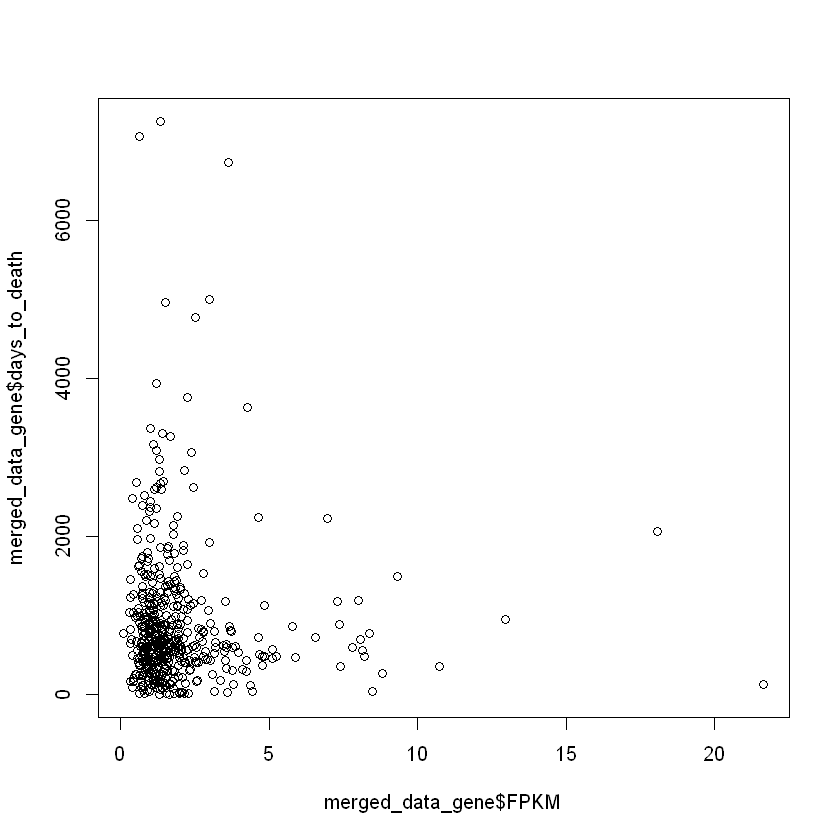

In [30]:
plot_scatter(
    rpkm_data, 
    clinical_data$all, 
    "ENSG00000168237", 
    "GLYCTK")

In [31]:
best_values_glyctk_all <- get_best_cutoff(
    rpkm_data, 
    clinical_data$all, 
    "ENSG00000168237", 
    title="GLYCTK", 
    stage="All")

[1] "All ::: GLYCTK"
[1] "Optimized cutoff: 0.913"
[1] "Best fit p-value: 0.0772322560260469"
[1] "high: 383"
[1] "low: 104"
Call:
coxph(formula = Surv(days_to_death, status) ~ FPKM, data = opt_categories)

  n= 487, number of events= 177 

          coef exp(coef) se(coef)    z Pr(>|z|)  
FPKMlow 0.2984    1.3478   0.1695 1.76   0.0784 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
FPKMlow     1.348      0.742    0.9667     1.879

Concordance= 0.524  (se = 0.019 )
Likelihood ratio test= 2.96  on 1 df,   p=0.09
Wald test            = 3.1  on 1 df,   p=0.08
Score (logrank) test = 3.12  on 1 df,   p=0.08



In [32]:
pdf("stat_dist_glyctk_all.pdf")
plot(
    best_values_glyctk_all$cutoff_obj, 
    "FPKM", 
    palette = "npg", 
    bins = 50)$FPKM
dev.off()

png 
  2

In [33]:
model <- best_values_glyctk_all$model
p_val <- best_values_glyctk_all$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_glyctk_all.pdf", onefile=FALSE)
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    break.time.by=1826.25,
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

png 
  2

#### Early stages

[1] "GLYCTK"


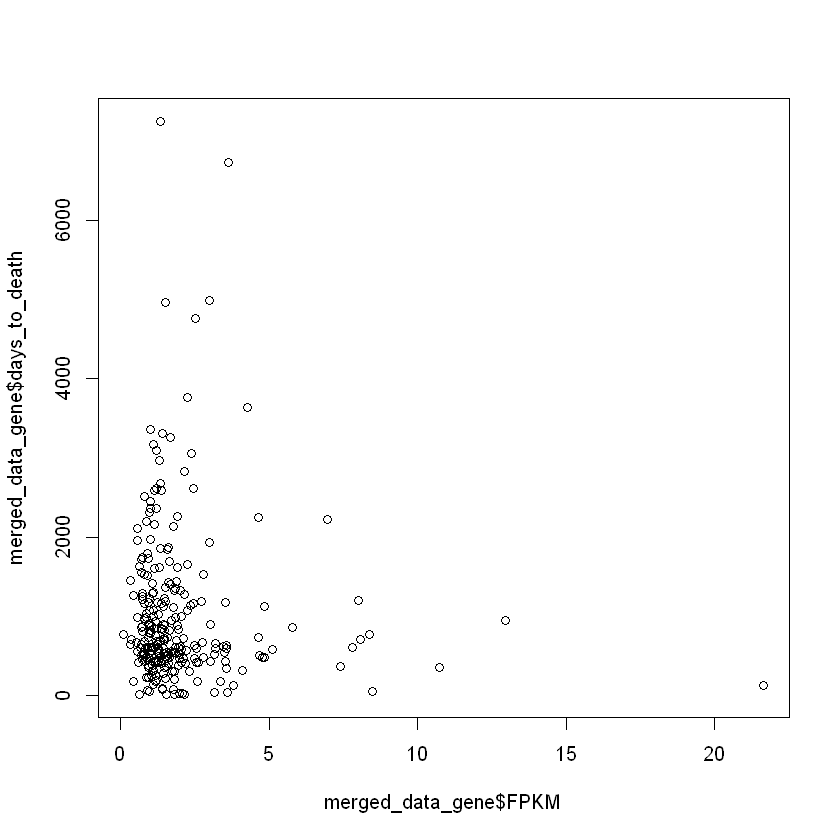

In [34]:
plot_scatter(
    rpkm_data, 
    clinical_data$early, 
    "ENSG00000168237", 
    "GLYCTK")

In [35]:
use_values_early <- use_cutoff(
    rpkm_data, 
    clinical_data$early, 
    "ENSG00000102172", 
    best_values_glyctk_all$cutoff, 
    title="GLYCTK", 
    stage="Early")

[1] "Early ::: GLYCTK"


Warning message in .pvalue(fit, data = data, method = method, pval = pval, pval.coord = pval.coord, :
"There are no survival curves to be compared. 
 This is a null model."


[1] "Used cutoff: 0.913"
[1] "Used p-value: NA"
[1] "high: 264"
[1] "low: 0"


ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


In [36]:
best_values_glyctk_early <- get_best_cutoff(
    rpkm_data, 
    clinical_data$early, 
    "ENSG00000168237", 
    title="GLYCTK", 
    stage="Early")

[1] "Early ::: GLYCTK"
[1] "Optimized cutoff: 0.9349"
[1] "Best fit p-value: 0.0257739806350333"
[1] "high: 212"
[1] "low: 52"
Call:
coxph(formula = Surv(days_to_death, status) ~ FPKM, data = opt_categories)

  n= 264, number of events= 63 

          coef exp(coef) se(coef)     z Pr(>|z|)  
FPKMlow 0.6140    1.8478   0.2798 2.195   0.0282 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
FPKMlow     1.848     0.5412     1.068     3.197

Concordance= 0.526  (se = 0.029 )
Likelihood ratio test= 4.44  on 1 df,   p=0.04
Wald test            = 4.82  on 1 df,   p=0.03
Score (logrank) test = 4.97  on 1 df,   p=0.03



In [37]:
pdf("stat_dist_glyctk_early.pdf")
plot(
    best_values_glyctk_early$cutoff_obj, 
    "FPKM", 
    palette = "npg", 
    bins = 50)$FPKM
dev.off()

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"


png 
  2

In [38]:
model <- best_values_glyctk_early$model
p_val <- best_values_glyctk_early$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_glyctk_early.pdf", onefile=FALSE)
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    break.time.by=1826.25,
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

png 
  2

#### Late stages

[1] "GLYCTK"


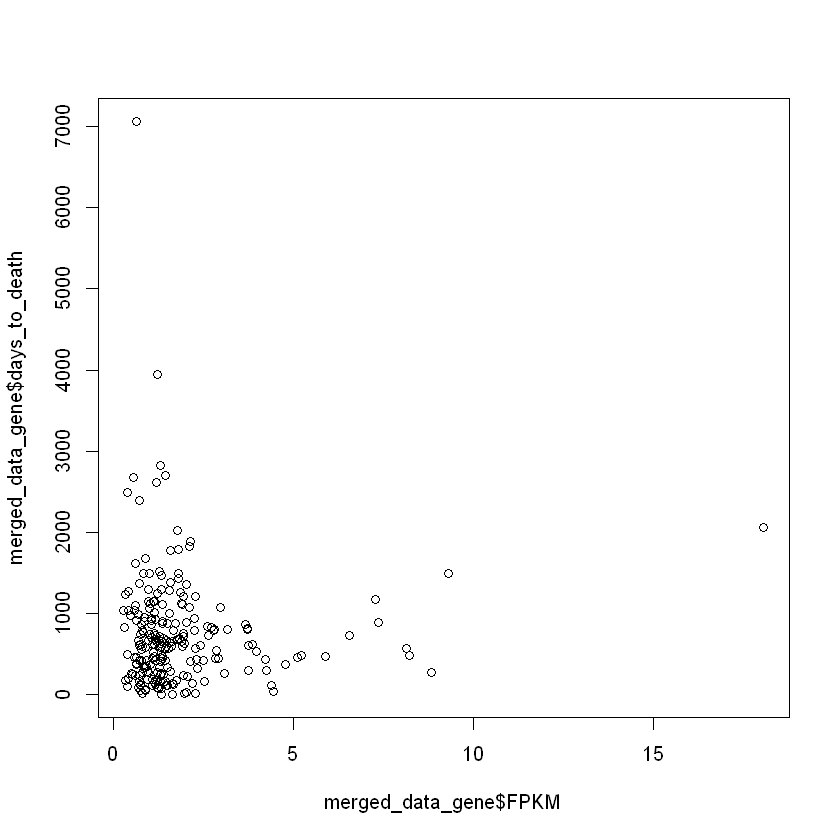

In [39]:
plot_scatter(
    rpkm_data, 
    clinical_data$late, 
    "ENSG00000168237", 
    "GLYCTK")

In [40]:
use_values_late <- use_cutoff(
    rpkm_data, 
    clinical_data$late, 
    "ENSG00000102172", 
    best_values_glyctk_all$cutoff, 
    title="GLYCTK", 
    stage="Late")

[1] "Late ::: GLYCTK"


Warning message in .pvalue(fit, data = data, method = method, pval = pval, pval.coord = pval.coord, :
"There are no survival curves to be compared. 
 This is a null model."


[1] "Used cutoff: 0.913"
[1] "Used p-value: NA"
[1] "high: 223"
[1] "low: 0"


ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


In [ ]:
best_values_glyctk_late <- get_best_cutoff(
    rpkm_data, 
    clinical_data$late, 
    "ENSG00000168237", 
    title="GLYCTK", 
    stage="late")

In [ ]:
pdf("stat_dist_glyctk_late.pdf")
plot(
    best_values_glyctk_late$cutoff_obj, 
    "FPKM", 
    palette = "npg", 
    bins = 50)$FPKM
dev.off()

In [ ]:
model <- best_values_glyctk_late$model
p_val <- best_values_glyctk_late$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_glyctk_late.pdf", onefile=FALSE)
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    break.time.by=1826.25,
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

### =========================================================================================

<a id="all"><h3>Perform analysis on all genes</h3></a> 

#### All stages

In [371]:
#all_genes_all <- analyze_all_genes(
#    rpkm_data, 
#    clinical_data$all, 
#    gene_list)

#### Early stages

In [372]:
#all_genes_early <- analyze_all_genes(
#    rpkm_data, 
#    clinical_data$early, 
#    gene_list)

#### Late stages

In [373]:
#all_genes_late <- analyze_all_genes(
#    rpkm_data, 
#    clinical_data$late, 
#    gene_list)

#### Write data

In [374]:
#write.table(all_genes_all$median, file = "all_genes_all_median.tsv", sep = "\t")
#write.table(all_genes_early$median, file = "all_genes_early_median.tsv", sep = "\t")
#write.table(all_genes_late$median, file = "all_genes_late_median.tsv", sep = "\t")

#write.table(all_genes_all$optimized, file = "all_genes_all_optimized.tsv", sep = "\t")
#write.table(all_genes_early$optimized, file = "all_genes_early_optimized.tsv", sep = "\t")
#write.table(all_genes_late$optimized, file = "all_genes_late_optimized.tsv", sep = "\t")

#### Read stored data

In [2]:
median_file <- read.csv(file = 'all_genes_all_median.tsv', sep="\t")
optimized_file <- read.csv(file = 'all_genes_all_optimized.tsv', sep="\t")

median_pvals <- as.list(median_file)
optimized_pvals <- as.list(optimized_file)

all_genes_all = list(median_pvals, optimized_pvals)
names(all_genes_all) <- c("median", "optimized")

In [3]:
median_file_early <- read.csv(file = 'all_genes_early_median.tsv', sep="\t")
optimized_file_early <- read.csv(file = 'all_genes_early_optimized.tsv', sep="\t")

median_pvals_early <- as.list(median_file_early)
optimized_pvals_early <- as.list(optimized_file_early)

all_genes_early = list(median_pvals_early, optimized_pvals_early)
names(all_genes_early) <- c("median", "optimized")

In [4]:
median_file_late <- read.csv(file = 'all_genes_late_median.tsv', sep="\t")
optimized_file_late <- read.csv(file = 'all_genes_late_optimized.tsv', sep="\t")

median_pvals_late <- as.list(median_file_late)
optimized_pvals_late <- as.list(optimized_file_late)

all_genes_late = list(median_pvals_late, optimized_pvals_late)
names(all_genes_late) <- c("median", "optimized")

<a id="rank"><h3>Rank order survival p-values</h3></a>

In [5]:
# Get ranked percentile
median_pvals_sorted <- all_genes_all$median[order(unlist(all_genes_all$median), decreasing=FALSE)]
median_pvals_early_sorted <- all_genes_early$median[order(unlist(all_genes_early$median), decreasing=FALSE)]
median_pvals_late_sorted <- all_genes_late$median[order(unlist(all_genes_late$median), decreasing=FALSE)]

optimized_pvals_sorted <- all_genes_all$optimized[order(unlist(all_genes_all$optimized), decreasing=FALSE)]
optimized_pvals_early_sorted <- all_genes_early$optimized[order(unlist(all_genes_early$optimized), decreasing=FALSE)]
optimized_pvals_late_sorted <- all_genes_late$optimized[order(unlist(all_genes_late$optimized), decreasing=FALSE)]

#### SMS

In [6]:
# Optimized

In [7]:
gene_name = "SMS"
gene_id = "ENSG00000102172"

print(paste(gene_name, "; optimized, all"))
print(paste("%ile:", (which(names(optimized_pvals_sorted) == gene_id) / length(optimized_pvals_sorted) * 100), "%"))
print(paste((which(names(optimized_pvals_sorted) == gene_id)), "/", length(optimized_pvals_sorted)))
print("")
print(paste(gene_name, "; optimized, early"))
print(paste("%ile:", (which(names(optimized_pvals_early_sorted) == gene_id) / length(optimized_pvals_early_sorted) * 100), "%"))
print(paste((which(names(optimized_pvals_early_sorted) == gene_id)), "/", length(optimized_pvals_early_sorted)))
print("")
print(paste(gene_name, "; optimized, late"))
print(paste("%ile:", (which(names(optimized_pvals_late_sorted) == gene_id) / length(optimized_pvals_late_sorted) * 100), "%"))
print(paste((which(names(optimized_pvals_late_sorted) == gene_id)), "/", length(optimized_pvals_late_sorted)))

[1] "SMS ; optimized, all"
[1] "%ile: 0.649457867796797 %"
[1] "118 / 18169"
[1] ""
[1] "SMS ; optimized, early"
[1] "%ile: 0.384869144490873 %"
[1] "70 / 18188"
[1] ""
[1] "SMS ; optimized, late"
[1] "%ile: 9.99393972783869 %"
[1] "1814 / 18151"


#### GLYCTK

In [8]:
# Optimized

In [9]:
gene_name = "GLYCTK"
gene_id = "ENSG00000168237"

print(paste(gene_name, "; optimized, all"))
print(paste("%ile:", (which(names(optimized_pvals_sorted) == gene_id) / length(optimized_pvals_sorted) * 100), "%"))
print(paste((which(names(optimized_pvals_sorted) == gene_id)), "/", length(optimized_pvals_sorted)))
print("")
print(paste(gene_name, "; optimized, early"))
print(paste("%ile:", (which(names(optimized_pvals_early_sorted) == gene_id) / length(optimized_pvals_early_sorted) * 100), "%"))
print(paste((which(names(optimized_pvals_early_sorted) == gene_id)), "/", length(optimized_pvals_early_sorted)))
print("")
print(paste(gene_name, "; optimized, late"))
print(paste("%ile:", (which(names(optimized_pvals_late_sorted) == gene_id) / length(optimized_pvals_late_sorted) * 100), "%"))
print(paste((which(names(optimized_pvals_late_sorted) == gene_id)), "/", length(optimized_pvals_late_sorted)))

[1] "GLYCTK ; optimized, all"
[1] "%ile: 62.7607463261599 %"
[1] "11403 / 18169"
[1] ""
[1] "GLYCTK ; optimized, early"
[1] "%ile: 16.3954255553112 %"
[1] "2982 / 18188"
[1] ""
[1] "GLYCTK ; optimized, late"
[1] "%ile: 94.1601013718252 %"
[1] "17091 / 18151"


<a id="plots"><h3>Plots</h3></a>

In [10]:
bump <- 1e-5

#### All stages

In [11]:
# Optimized

In [12]:
# Plot distribution
optimized_pvals_bh <- p.adjust(
  optimized_pvals_sorted, 
  method = "BH", 
  n = length(optimized_pvals_sorted))

pdf('bh_dist_all.pdf', width=10, height=5)
hist(
  -1 * log10(as.numeric(optimized_pvals_bh) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(optimized_pvals_bh['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(optimized_pvals_bh['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)
dev.off()

png 
  2

In [13]:
# Correlation of survival vs ranking
# Ranked "Average" patterns with at least 2 significant components

average_ranked_genes <- list(
    "SMS",
    "GLYCTK",
    "PGP",
    "UPP1", "UPP2",
    "UPP1", "UPP2",
    "ODC1",
    "TREH",
    #"SI", <- not in data
    "AMY1A", "AMY1B", "AMY2A", "AMY2B", #"AMY1C", <- not in data
    "MGAM",
    "XDH"
)

average_ranked_gene_ids <- list(
    "ENSG00000102172",
    "ENSG00000168237",
    "ENSG00000184207",
    "ENSG00000183696", "ENSG00000007001",
    "ENSG00000183696", "ENSG00000007001",
    "ENSG00000115758",
    "ENSG00000118094",
    #"ENSG00000090402", <- not in data
    "ENSG00000237763", "ENSG00000174876", "ENSG00000243480", "ENSG00000240038", #"ENSG00000187733", <- not in data
    "ENSG00000257335",
    "ENSG00000158125"
)

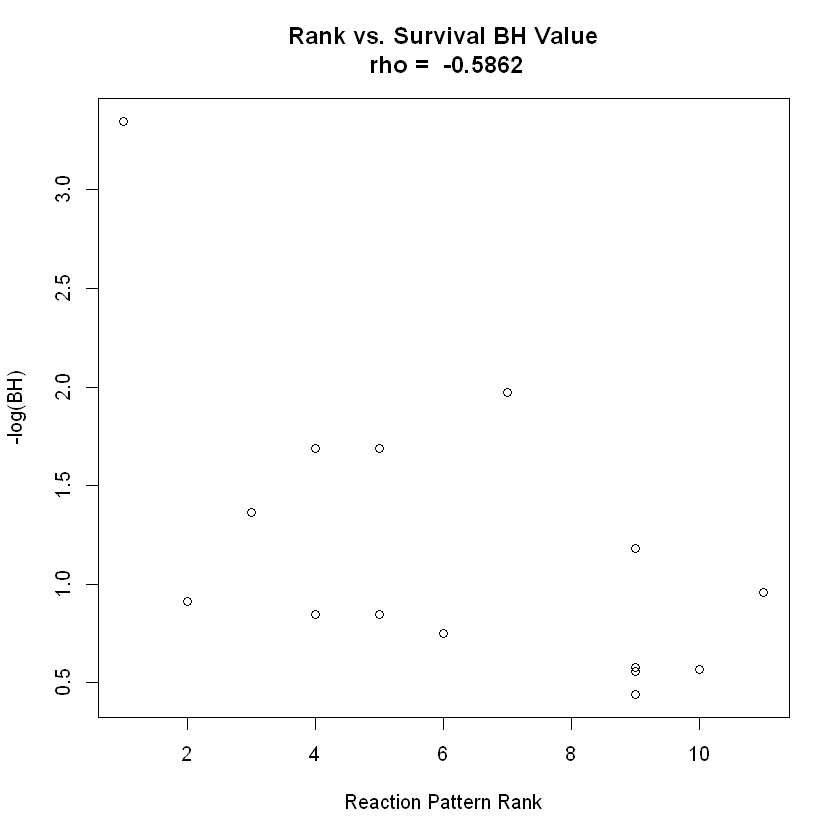

In [14]:
counter <- list(
    1,
    2,
    3,
    4,4,
    5,5,
    6,
    7,
    #8, <- not in data
    9,9,9,9, #9,<- not in data
    10,
    11
)
bh_vals <- list()

for (x in average_ranked_gene_ids) {
    bh_vals <- c(bh_vals, -1 * log10(optimized_pvals_bh[x]))
}

#tiff('bh_vs_rank.tiff', units="in", width=5, height=5, res=300)
plot(
    counter, 
    as.numeric(bh_vals), 
    main=paste(
        "Rank vs. Survival BH Value\n", 
        "rho = ", round(cor(as.numeric(counter), as.numeric(bh_vals), method = "pearson"), digits=4)),
    xlab="Reaction Pattern Rank", 
    ylab="-log(BH)")
#dev.off()

In [15]:
library("ggpubr")

In [16]:
rank_data <- t(rbind("Rank"=as.numeric(counter), "BH_val"=as.numeric(bh_vals)))

In [17]:
rank_data

Rank BH_val   
 [1,]  1   3.3480423
 [2,]  2   0.9099012
 [3,]  3   1.3644380
 [4,]  4   1.6897581
 [5,]  4   0.8450903
 [6,]  5   1.6897581
 [7,]  5   0.8450903
 [8,]  6   0.7510583
 [9,]  7   1.9727897
[10,]  9   0.5778943
[11,]  9   0.5549917
[12,]  9   0.4398202
[13,]  9   1.1804783
[14,] 10   0.5672358
[15,] 11   0.9565426

In [19]:
tiff('supp_fig_15-bh_vs_rank.tiff', units="in", width=7, height=5, res=600)

p <- ggscatter(
    as.data.frame(rank_data), x = "Rank", y = "BH_val", 
    add = "loess", conf.int = TRUE, cor.coef = TRUE, cor.method = "pearson",
    color = "black", shape = 19, size = 4, add.params = list(fill = "lightgray"),
    main="Rank vs. Survival BH Value", xlab = "Reaction Pattern Rank",
    font.label = c(6, "bold"),
    cor.coef.coord = c(7,3.5), cor.coef.size = 6)
p + 
    font("title", size = 24)+ 
    font("xlab", size = 18)+
    font("ylab", size = 18)+
    font("xy.text", size = 16)+ 
    theme(plot.title = element_text(hjust = 0.5))+ 
    scale_x_continuous(breaks = seq(1, 13, by = 2))+
    labs(y=expression(-log[1*0]*"(Survival BH)"))

dev.off()

`geom_smooth()` using formula 'y ~ x'



png 
  2

#### Early stages

In [14]:
# Optimized

In [15]:
# Plot distribution
optimized_pvals_bh_early <- p.adjust(
  optimized_pvals_early_sorted, 
  method = "BH", 
  n = length(optimized_pvals_early_sorted))

pdf('bh_dist_early.pdf')
hist(
  -1 * log10(as.numeric(optimized_pvals_bh_early) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(optimized_pvals_bh_early['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(optimized_pvals_bh_early['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)
dev.off()

png 
  2

#### Late Stages

In [16]:
# Optimized

In [17]:
# Plot distribution
optimized_pvals_bh_late <- p.adjust(
  optimized_pvals_late_sorted, 
  method = "BH", 
  n = length(optimized_pvals_late_sorted))

pdf('bh_dist_late.pdf')
hist(
  -1 * log10(as.numeric(optimized_pvals_bh_late) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(optimized_pvals_bh_late['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(optimized_pvals_bh_late['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)
dev.off()

png 
  2

#### Checks

In [18]:
# Does average expression of gene correlate with rank?
# Does it selectively correlate with lower expressed genes? (FPKM < 2)
# Correlate with variance?

In [19]:
corr_matrix <- data.frame(matrix((optimized_pvals_bh), nrow=length(optimized_pvals_bh), byrow=TRUE),stringsAsFactors=FALSE)

In [20]:
rownames(corr_matrix) <- names(optimized_pvals_bh)

In [21]:
colnames(corr_matrix) <- "bh_val"

In [22]:
corr_matrix[, "median_expr"] <- 0

In [23]:
corr_matrix[, "gene"] <- rownames(corr_matrix)

In [24]:
for (x in rownames(corr_matrix)) {
    
    corr_matrix[x, "median_expr"] <- median(
        rpkm_data$FPKM[rpkm_data$Gene == x]
    )

}

ERROR: Error in median(rpkm_data$FPKM[rpkm_data$Gene == x]): object 'rpkm_data' not found


In [25]:
for (x in rownames(corr_matrix)) {
    
    corr_matrix[x, "variance"] <- var(
        rpkm_data$FPKM[rpkm_data$Gene == x]
    )

}

ERROR: Error in is.data.frame(x): object 'rpkm_data' not found


In [26]:
plot_matrix = corr_matrix
#plot_matrix = corr_matrix[corr_matrix$median_expr < 1, ]

In [27]:
pdf('corr_matrix_median.pdf')
plot(
    -1 * log(plot_matrix$bh_val), 
    (plot_matrix$median_expr), 
    main=paste("Pearson: ", cor(-1 * log(plot_matrix$bh_val), (plot_matrix$median_expr),  method = "pearson")),
    xlab="-log10(BH)", 
    ylab="Median expression", 
    pch=19,
    col = rgb(red = 0, green = 0, blue = 0, alpha = 0.2))
dev.off()

Warning message in cor(-1 * log(plot_matrix$bh_val), (plot_matrix$median_expr), :
"the standard deviation is zero"


png 
  2

In [28]:
cor(-1 * log(plot_matrix$bh_val), (plot_matrix$median_expr),  method = "pearson")

Warning message in cor(-1 * log(plot_matrix$bh_val), (plot_matrix$median_expr), :
"the standard deviation is zero"


[1] NA

In [29]:
pdf('corr_matrix_var.pdf')
plot(
    -1 * log(plot_matrix$bh_val), 
    (plot_matrix$variance), 
    main=paste("Pearson: ", cor(-1 * log(plot_matrix$bh_val), (plot_matrix$variance),  method = "pearson")),
    xlab="-log10(BH)", 
    ylab="Gene variance", 
    pch=19,
    col = rgb(red = 0, green = 0, blue = 0, alpha = 0.2))
dev.off()

ERROR: Error in cor(-1 * log(plot_matrix$bh_val), (plot_matrix$variance), method = "pearson"): supply both 'x' and 'y' or a matrix-like 'x'


In [30]:
cor(-1 * log(plot_matrix$bh_val), (plot_matrix$variance),  method = "pearson")

ERROR: Error in cor(-1 * log(plot_matrix$bh_val), (plot_matrix$variance), method = "pearson"): supply both 'x' and 'y' or a matrix-like 'x'


In [31]:
pdf('corr_matrix_median_var.pdf')
plot(
    log(plot_matrix$median_expr), 
    log(plot_matrix$variance), 
    main=paste("Pearson: ", cor((plot_matrix$median_expr), (plot_matrix$variance),  method = "pearson")),
    xlab="Median expression", 
    ylab="Gene variance", 
    pch=19,
    col = rgb(red = 0, green = 0, blue = 0, alpha = 0.2))
dev.off()

ERROR: Error in log(plot_matrix$variance): non-numeric argument to mathematical function


In [32]:
cor((plot_matrix$median_expr), (plot_matrix$variance),  method = "pearson")

ERROR: Error in cor((plot_matrix$median_expr), (plot_matrix$variance), method = "pearson"): supply both 'x' and 'y' or a matrix-like 'x'


In [33]:
library(org.Hs.eg.db)

Warning message:
"package 'org.Hs.eg.db' was built under R version 4.0.3"
Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique

In [34]:
symbols <- mapIds(org.Hs.eg.db, keys = rownames(plot_matrix), keytype = "ENSEMBL", column="SYMBOL")

'select()' returned 1:many mapping between keys and columns



In [35]:
plot_matrix$name <- symbols

In [36]:
depmap <- read.csv(
    file = 'CRISPR_(DepMap_21Q4_Public+Score,_Chronos)_subsetted_NSCLC.csv', 
    sep=",")

In [37]:
depmap <- t(depmap)

In [38]:
depmap_c <- depmap[7:length(rownames(depmap)),]

In [39]:
plot_matrix_copy <- plot_matrix

In [40]:
plot_matrix_copy["id"] <- rownames(plot_matrix_copy)

In [41]:
for (x in plot_matrix_copy[, "name"]) {
    this_index <- row.names(plot_matrix_copy)[which(plot_matrix_copy$name==x)]
    
    if (x %in% rownames(depmap_c)) {
        this_median <- median(
            as.numeric(unlist(
                depmap_c[x, ][!is.na(depmap_c[x, ])]
                )))

        plot_matrix_copy[this_index, "med_dep_score"] <- this_median
    }

}

In [42]:
plot_matrix_copy_2 <- plot_matrix_copy[!is.na(plot_matrix_copy$med_dep_score), ]

In [43]:
plot_matrix_copy_3 <- plot_matrix_copy[plot_matrix_copy$name %in% list(
    "SMS", "SPN", "GLYCTK", "PGP", "ACSM1", "UPP1", "UPP2", "ODC1", "MGAM", "AMY2A", "ADK"),]

In [44]:
plot_matrix_copy_3

bh_val       median_expr gene            name   id             
ENSG00000102172 0.0004487017 0           ENSG00000102172 SMS    ENSG00000102172
ENSG00000197471 0.0101915459 0           ENSG00000197471 SPN    ENSG00000197471
ENSG00000183696 0.0204287537 0           ENSG00000183696 UPP1   ENSG00000183696
ENSG00000156110 0.0407724419 0           ENSG00000156110 ADK    ENSG00000156110
ENSG00000184207 0.0432077846 0           ENSG00000184207 PGP    ENSG00000184207
ENSG00000166743 0.0860783074 0           ENSG00000166743 ACSM1  ENSG00000166743
ENSG00000168237 0.1230548714 0           ENSG00000168237 GLYCTK ENSG00000168237
ENSG00000007001 0.1428596855 0           ENSG00000007001 UPP2   ENSG00000007001
ENSG00000115758 0.1773951212 0           ENSG00000115758 ODC1   ENSG00000115758
ENSG00000257335 0.2708720828 0           ENSG00000257335 MGAM   ENSG00000257335
ENSG00000243480 0.3632283962 0           ENSG00000243480 AMY2A  ENSG00000243480
                med_dep_score
ENSG00000102172 -0.47489558  
ENSG00000197471  0.02523694  
ENSG00000183696  0.10748667  
ENSG00000156110 -0.06338164  
ENSG00000184207 -0.11760761  
ENSG00000166743  0.05073574  
ENSG00000168237 -0.02442754  
ENSG00000007001 -0.02051014  
ENSG00000115758  0.03944082  
ENSG00000257335  0.06806851  
ENSG00000243480 -0.01932228

In [45]:
plot_matrix_copy_4 <- plot_matrix_copy_2[plot_matrix_copy_2$med_dep_score < -0.2,]

In [46]:
pdf('corr_matrix_bh_v_depmap.pdf')
plot(
    -1 * log(plot_matrix_copy_4$bh_val + bump), 
    (plot_matrix_copy_4$med_dep_score), 
    main=paste("Pearson: ", cor(-1 * log(plot_matrix_copy_4$bh_val + bump), (plot_matrix_copy_4$med_dep_score),  method = "pearson")),
    xlab="KM Score", 
    ylab="DepMap score", 
    pch=19,
    col = rgb(red = 0, green = 0, blue = 0, alpha = 0.1))
dev.off()

png 
  2

<a id="session"><h3>Session Info</h3></a>

In [237]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22000)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] org.Hs.eg.db_3.11.4  AnnotationDbi_1.50.3 IRanges_2.22.2      
 [4] S4Vectors_0.26.1     Biobase_2.48.0       BiocGenerics_0.34.0 
 [7] data.table_1.13.6    stringr_1.4.0        survminer_0.4.9     
[10] ggpubr_0.4.0         ggplot2_3.3.3        survival_3.2-11     

loaded via a namespace (and not attached):
 [1] tidyr_1.1.2       bit64_4.0.5       jsonlite_1.7.2    splines_4.0.2    
 [5] carData_3.0-4     assertthat_0.2.1  blob_1.2.1        cellranger_1.1.0 
 [9] pillar_1.6.